# Midterm

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session

sns.set_style("whitegrid")
sns.set_context("paper")

In [2]:
output_path = Path() / "midterm_output"
output_path.mkdir(parents=True, exist_ok=True)

service = QiskitRuntimeService(channel="ibm_quantum")
backend_sim = service.get_backend("ibmq_qasm_simulator")
backend_qc = service.least_busy(simulator=False)

## Step 1

In [3]:
def overlap(theta):
    return 0.5 * (1 + np.sin(theta))

In [4]:
theta_array = np.linspace(0, 2 * np.pi, 50)
r_array = overlap(theta_array)
data = pd.DataFrame({"theta": theta_array, "r_theory": r_array})
data.head()

,theta,r_theory
0,0.000000,0.500000
1,0.128228,0.563939
2,0.256457,0.626827
3,0.384685,0.687634
4,0.512913,0.745359


## Step 2

### Bell measurement

In [ ]:
def phi2(theta):
    return [np.cos(theta / 2), np.sin(theta / 2)]

def bell_circuit(theta):
    circuit = QuantumCircuit(2)
    circuit.initialize([1 / np.sqrt(2), 1 / np.sqrt(2)], 0)  # \ket{+} on first qubit
    circuit.initialize(phi2(theta), 1)  # \ket{phi_2} on secund qubit
    circuit.cnot(0, 1)
    circuit.h(0)
    circuit.measure_all()
    return circuit

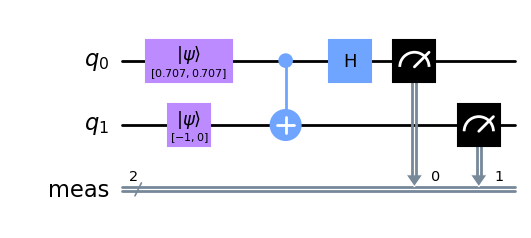

In [59]:
theta = 2 * np.pi  # Just an example for plotting
circuit_example = bell_circuit(theta)
circuit_example.draw("mpl", plot_barriers=False, filename=output_path / "circuit.png")

In [9]:
## Simulator
with Session(service=service, backend=backend_sim) as session_sim:
    sampler = Sampler(session=session_sim)
    job = sampler.run([bell_circuit(theta) for theta in theta_array])
    result = job.result()
    r_sim = np.array([1 - 2 * quasi_dist[3] for quasi_dist in result.quasi_dists])
    data["r_sim"] = r_sim

In [10]:
## Quantum Computer
with Session(service=service, backend=backend_qc) as session_qc:
    sampler = Sampler(session=session_qc)
    job = sampler.run([bell_circuit(theta) for theta in theta_array])
    result = job.result()
    r_qc = np.array([1 - 2 * quasi_dist[3] for quasi_dist in result.quasi_dists])
    data["r_qc"] = r_qc

In [ ]:
data.to_csv(output_path / "experiment_20231029.csv")

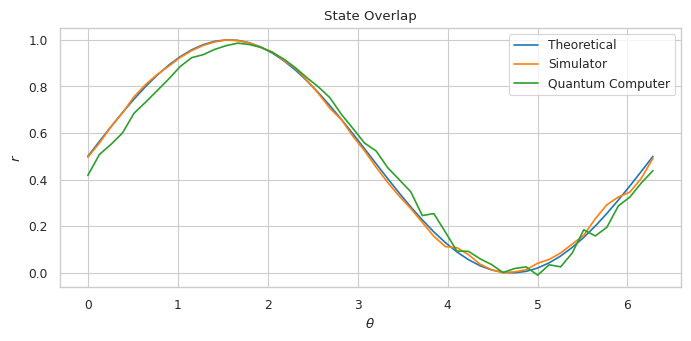

In [54]:
fig, ax = plt.subplots(figsize=(7, 3.5))
ax.plot(data["theta"], data["r_theory"], label="Theoretical")
ax.plot(data["theta"], data["r_sim"], label="Simulator")
ax.plot(data["theta"], data["r_qc"], label="Quantum Computer")
ax.legend()
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$r$")
ax.set_title("State Overlap")
fig.tight_layout()
fig.savefig(output_path / "state_overlap.png", dpi=300)